In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
PATH = "../../data/labels/new/sample_result_100/"
FILES = {name.split(".")[0]: os.path.join(PATH, name) for name in os.listdir(PATH)}

In [3]:
FILES

{'Q11': '../../data/labels/new/sample_result_100/Q11.csv',
 'Q9': '../../data/labels/new/sample_result_100/Q9.csv',
 'Q1': '../../data/labels/new/sample_result_100/Q1.csv',
 'Q2_7': '../../data/labels/new/sample_result_100/Q2_7.csv',
 'Q12': '../../data/labels/new/sample_result_100/Q12.csv',
 'Q10': '../../data/labels/new/sample_result_100/Q10.csv'}

In [4]:
raw = {file: pd.read_csv(path) for file, path in FILES.items()}

In [5]:
print("file  shape      unique workders")
for file, df in raw.items():
    print("%4s  %s  %d" % (file, df.shape, len(df.WorkerId.unique())))

file  shape      unique workders
 Q11  (300, 40)  22
  Q9  (300, 41)  23
  Q1  (300, 53)  29
Q2_7  (300, 40)  39
 Q12  (300, 40)  26
 Q10  (300, 40)  29


In [6]:
def preprocess_melt_pivot(df, melt_ids, melt_values):
    # base df
    base = df[["AssignmentId", "Input.image_url"]].sort_values(by="Input.image_url").drop_duplicates()
    
    # questions
    q = df.melt(id_vars=melt_ids, value_vars=melt_values)
    q = q[q.value == True]
    q["value"] = pd.DataFrame(q.variable.str.split(".", expand=True))[2]
    q["variable"] = pd.DataFrame(q.variable.str.split(".", expand=True))[1]
    
    # merge
    result = pd.merge(left=base, right=q.pivot(index="AssignmentId", columns="variable", values="value"), on="AssignmentId")
    return result

In [7]:
### shared melt_ids
melt_ids = ['AssignmentId', 'WorkerId', 'Input.image_url']

### Q1
# Answer.q1_body_extent.<1-10>
# Answer.q1_buck_extent.<1-10>
# Answer.q1_option.<yes, no, no_bucket>
q1_melt_values = ['Answer.q1_body_extent.' + str(i) for i in range(1, 11)] \
                 + ['Answer.q1_buck_extent.' + str(i) for i in range(1, 11)] \
                 + ['Answer.q1_option.' + str(i) for i in ['yes', 'no', 'no_bucket']]

### Q2_7
# Answer.q<2-5,7>_ojption.<yes, no>
q2_7_melt_values = ["Answer.q"+str(i)+"_option."+j for i in [2, 3, 4, 5, 7] for j in ["yes", "no"]]

### Q9
# Answer.q9_extent.<1-11>
q9_melt_values = ["Answer.q9_extent."+str(i) for i in range(1, 12)]

### Q10
# Answer.q10_extent.<1-10>
q10_melt_values = ["Answer.q10_extent."+str(i) for i in range(1, 11)]

### Q11
# Answer.q11_extent.<1-10>
q11_melt_values = ["Answer.q11_extent."+str(i) for i in range(1, 11)]

### Q12
# Answer.q12_extent.<1-10>
q12_melt_values = ["Answer.q12_extent."+str(i) for i in range(1, 11)]

### Q_all
NAMES = ["Q1", "Q2_7", "Q9", "Q10", "Q11", "Q12"]
Q_DFS = [q1_melt_values, q2_7_melt_values, q9_melt_values, q10_melt_values, q11_melt_values, q12_melt_values]
melt_values = {name: q_df for name, q_df in zip(NAMES, Q_DFS)}

In [8]:
# q1 = preprocess_melt_pivot(df=raw["Q1"], melt_ids=melt_ids, melt_values=q1_melt_values)
# q2_7 = preprocess_melt_pivot(df=raw["Q2_7"], melt_ids=melt_ids, melt_values=q2_7_melt_values)
# q9 = preprocess_melt_pivot(df=raw["Q9"], melt_ids=melt_ids, melt_values=q9_melt_values)
# q10 = preprocess_melt_pivot(df=raw["Q10"], melt_ids=melt_ids, melt_values=q10_melt_values)
# q11 = preprocess_melt_pivot(df=raw["Q11"], melt_ids=melt_ids, melt_values=q11_melt_values)
# q12 = preprocess_melt_pivot(df=raw["Q12"], melt_ids=melt_ids, melt_values=q12_melt_values)

# create a dictionary of dataframes and a concatenated dataframe
q_df = {name: preprocess_melt_pivot(df=raw[name], melt_ids=melt_ids, melt_values=melt_values[name]) for name in NAMES}
q_concat = pd.concat([q_df["Q1"]["Input.image_url"]]+[q_df[name].drop(columns=["AssignmentId", "Input.image_url"]) for name in NAMES], axis=1)

# change the dtype
dtypes = ["str"] + 2*["float"] + 6*["category"] + 4*["float"]
for col, dtype in zip(q_concat.columns, dtypes):
    q_concat[col] = q_concat[col].astype(dtype)

In [9]:
q_concat

,Input.image_url,q1_body_extent,q1_buck_extent,q1_option,q2_option,q3_option,q4_option,q5_option,q7_option,q9_extent,q10_extent,q11_extent,q12_extent
0,bigiron_1053.jpg,10.0,10.0,yes,yes,no,no,no,yes,4.0,7.0,10.0,6.0
1,bigiron_1053.jpg,5.0,3.0,yes,no,no,no,no,yes,5.0,6.0,5.0,5.0
2,bigiron_1053.jpg,6.0,4.0,yes,no,no,no,no,yes,7.0,7.0,7.0,5.0
3,bigiron_1AB878.jpg,3.0,7.0,yes,no,no,no,yes,yes,6.0,1.0,7.0,8.0
4,bigiron_1AB878.jpg,6.0,8.0,yes,yes,yes,no,no,yes,9.0,4.0,6.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,bigiron_BY0134.jpg,1.0,9.0,yes,no,no,no,no,yes,5.0,10.0,3.0,8.0
296,bigiron_BY0134.jpg,8.0,6.0,yes,yes,yes,no,yes,yes,8.0,9.0,7.0,8.0
297,bigiron_CA0091.jpg,7.0,NaN,no,yes,yes,yes,no,yes,6.0,8.0,7.0,7.0
298,bigiron_CA0091.jpg,4.0,NaN,no,yes,no,yes,yes,yes,2.0,7.0,7.0,7.0


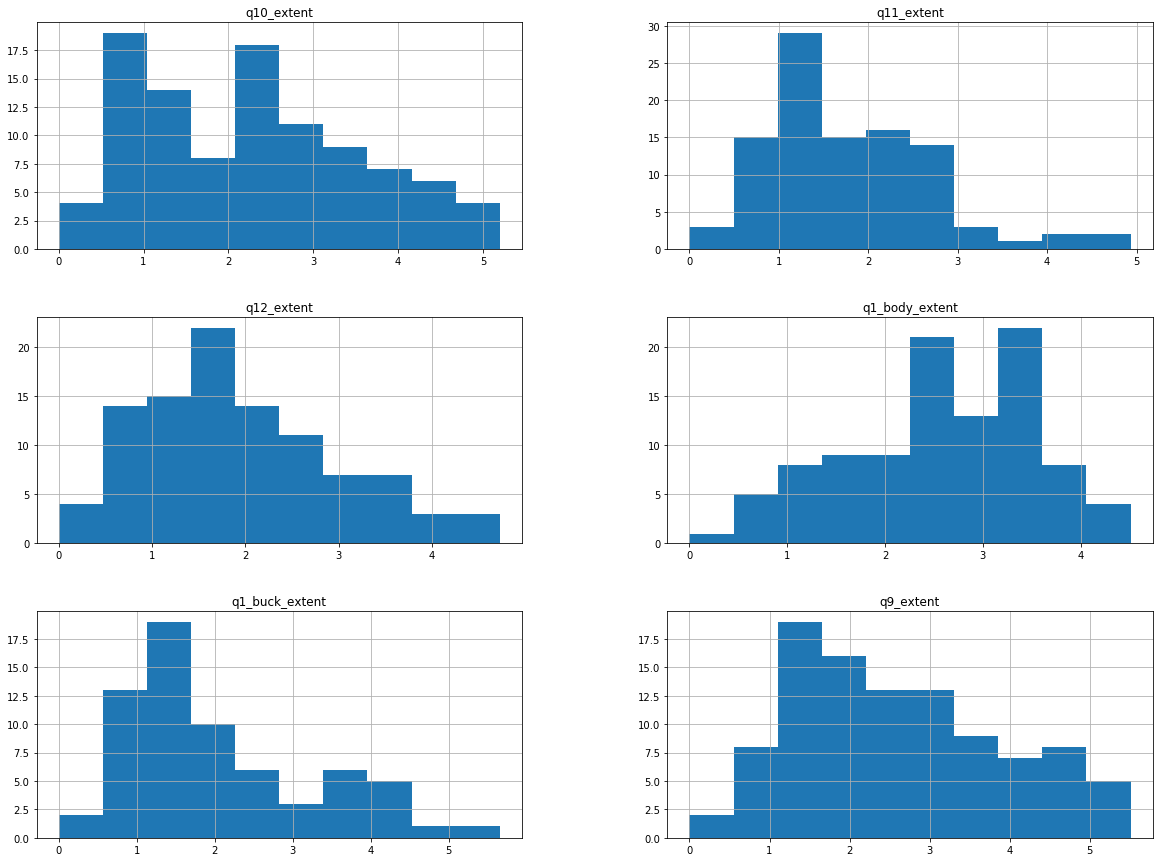

In [10]:
# distribution of standard deviation for all the answers for each image
q_concat.groupby("Input.image_url").std().hist(figsize=(20, 15))
plt.show()

In [11]:
def eval_categorical_column(df, col):
    temp = df.groupby("Input.image_url")[col].value_counts()
    count_3 = (temp == 3).sum()
    count_21 = (temp == 2).sum()
    if count_3 + count_21 == len(df)/3:
        num_cat = 2
    else:
        num_cat = 3
        count_111 = (len(temp) - count_3 - 2*count_21) / 3
    print("%s - %d categories:" % (col, num_cat))
    print("\"300\"  %d" % count_3)
    print("\"210\"  %d" % count_21)
    if num_cat == 3:
        print("\"111\"  %d" % count_111)
    print("")

In [12]:
# counts of different combination of answers for each category
eval_categorical_column(q_concat, "q1_option")
eval_categorical_column(q_concat, "q2_option")
eval_categorical_column(q_concat, "q3_option")
eval_categorical_column(q_concat, "q4_option")
eval_categorical_column(q_concat, "q5_option")
eval_categorical_column(q_concat, "q7_option")

q1_option - 3 categories:
"300"  51
"210"  45
"111"  4

q2_option - 2 categories:
"300"  48
"210"  52

q3_option - 2 categories:
"300"  68
"210"  32

q4_option - 2 categories:
"300"  63
"210"  37

q5_option - 2 categories:
"300"  40
"210"  60

q7_option - 2 categories:
"300"  81
"210"  19

